In [1]:


import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import iris
import iris.quickplot as qplt
import iris.plot as iplt
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import esmvalcore.preprocessor
import xesmf as xe
import warnings
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.interpolate import interp1d
from sklearn import metrics
import dask
from tqdm import tqdm
from nc_processing import calc_spatial_mean
from mpl_axes_aligner import align
#sns.set()

from xmip.preprocessing import rename_cmip6
import matplotlib.path as mpath

def read_in(dir, ocean = False):
    files = []
    for x in os.listdir(dir):
        files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, engine='netcdf4'))
    return ds

def read_in_ens_mean(dirs, ocean = False, zonal_mean=False, max_ens_members=False):
    """ returns the ensemble mean dataset """
    
    files = []
    if max_ens_members:
        dirs = dirs[0:max_ens_members]
    for dir in dirs:
        for x in os.listdir(dir):
            if '.nc' in x:
                files.append(dir + x)
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = rename_cmip6(xr.open_mfdataset(files, use_cftime=True, concat_dim='ensemble',combine='nested'))
        n_ens = len(ds.ensemble) 
        ds = ds.mean(dim='ensemble')
        if zonal_mean:
            ds = ds.mean(dim='x')
        ds['number_ens_mems_meaned'] = n_ens
    return ds

def get_gmst(ds):
    return calc_spatial_mean(ds.tas.mean(dim="time"), lon_name="x", lat_name="y").values

def get_dirs(var, model, scenario, table='Amon'):
    if scenario == 'ARISE':
        dirs = glob.glob('/badc/deposited2022/arise/data/ARISE/MOHC/UKESM1-0-LL/arise-sai-1p5/*/{t}/{v}/*/*/'.format(
            t=table, v=var))
    else:
        dirs = glob.glob('/badc/cmip6/data/CMIP6/*/*/{m}/{s}/*/{t}/{v}/*/latest/'.format(
            m=model, s=scenario, t=table, v=var))
    weird_jasmin_vars = ['rlds', 'rlus'] 
    if model == 'UKESM1-0-LL': # weird error on opening several files, perhaps corrupted?
        if var == 'rlds':
            dirs = dirs[0:2]
        if var == 'rlus':
            dirs = dirs[1:]
    return dirs


def get_all_vars_zonal_monthly(vars, model, scenario,
                                min_year="2080", max_year="2100"):
    ds_list = []
    for var in tqdm(vars):
        ds = read_in_ens_mean(get_dirs(var, model, scenario, table='Amon'),
                              ocean=False, zonal_mean=True,
                              max_ens_members=False)
        ds_list.append(ds)
    
    DS = xr.merge(ds_list, compat='override')
    
    ## take an arctic spatial mean:
    #DS = DS.sel(y=slice(min_lat, max_lat))
    #weights = np.cos(np.deg2rad(DS.y))
    #weights.name = "weights"
    #DS_weighted = DS.weighted(weights)
    #DS_smean = DS_weighted.mean("y")
    
    ## take late-century monthly time-mean
    DS_stmean = DS.sel(time=slice(min_year, max_year)).groupby("time.month").mean(dim="time")
    
    return DS_stmean

def get_surface_area_north_of_lat(min_lat):
    path = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/fx/areacella/gn/latest/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc'
    areacella = rename_cmip6(xr.open_dataset(path))
    out = areacella.sel(y=slice(min_lat, 90.1)).sum(dim=['x', 'y']).areacella.values*1
    return out


##### SETTINGS
model = 'UKESM1-0-LL'
var = 'tas'
scenarios = ['G6sulfur', 'ssp245', 'ssp585']#, 'ARISE']
#min_lat, max_lat = 70, 90
min_year_late_cent, max_year_late_cent = "2070", "2100"

do_preprocess = True

plt.rcParams.update({'font.size': 18})




In [62]:
def get_gmst(model):
    dir_pi = glob.glob('/badc/cmip6/data/CMIP6/*/*/{}/piControl/r1i*/Amon/tas/*/latest/'.format(model))
    files_pi = os.listdir(dir_pi[0])[0:3] # don't need the full length run
    paths_pi = []
    for x in files_pi:
        paths_pi.append(dir_pi[0]+x)
    da_pi = rename_cmip6(xr.open_mfdataset(paths_pi)).tas.mean(dim='x')
    da_pi = da_pi.weighted(weights=np.cos(np.deg2rad(da_pi.y))).mean(dim='y')
    
    gmst_pi = da_pi.mean(dim='time').values
    print(gmst_pi)
    return gmst_pi

In [54]:
model = 'CESM2-WACCM'
ds_750 = read_in_ens_mean(glob.glob('/badc/cmip6/data/CMIP6/C4MIP/*/{}/esm-1pct-brch-750PgC/*/Amon/tas/gn/latest/'.format(model)))
ds_1000 = read_in_ens_mean(glob.glob('/badc/cmip6/data/CMIP6/C4MIP/*/{}/esm-1pct-brch-1000PgC/*/Amon/tas/gn/latest/'.format(model)))
ds_119 = read_in_ens_mean(glob.glob('/badc/cmip6/data/CMIP6/ScenarioMIP/*/{}/ssp119/*/Amon/tas/gn/latest/'.format(model)))

da_750 = ds_750.tas.mean(dim='x') - gmst_pi
da_750 = da_750.weighted(weights=np.cos(np.deg2rad(da_750.y))).mean(dim='y').compute()
da_750 = da_750.groupby("time.year").mean(dim="time").compute()


da_1000 = ds_1000.tas.mean(dim='x') - gmst_pi
da_1000 = da_1000.weighted(weights=np.cos(np.deg2rad(da_1000.y))).mean(dim='y')
da_1000 = da_1000.groupby("time.year").mean(dim="time").compute()

da_119 = ds_119.tas.mean(dim='x') - gmst_pi
da_119 = da_119.weighted(weights=np.cos(np.deg2rad(da_119.y))).mean(dim='y')
da_119 = da_119.groupby("time.year").mean(dim="time").compute()



In [63]:
def get_da(path, model):
    ds = read_in_ens_mean(glob.glob(path))
    da = ds.tas.mean(dim='x') - get_gmst(model)
    da = da.weighted(weights=np.cos(np.deg2rad(da.y))).mean(dim='y').compute()
    da = da.groupby("time.year").mean(dim="time").compute()
    return da



In [72]:
model = 'UKESM1-0-LL'

path = '/badc/cmip6/data/CMIP6/C4MIP/*/{}/esm-1pct-brch-750PgC/*/Amon/tas/gn/latest/'.format(model)
#path = '/badc/cmip6/data/CMIP6/ScenarioMIP/*/{}/ssp119/*/Amon/tas/gn/latest/'.format(model)
#path = '/badc/cmip6/data/CMIP6/ScenarioMIP/*/{}/ssp126/*/Amon/tas/gn/latest/'.format(model)

In [73]:
da = get_da(path=path, model=model)

286.52036529129015


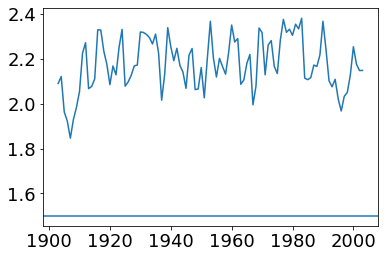

In [74]:
plt.plot(da.year, da)
plt.axhline(1.5)

In [4]:
glob.glob('/badc/cmip6/data/CMIP6/ScenarioMIP/*/CESM2-WACCM/*/*/Amon/co2/')

['/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/Amon/co2/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r2i1p1f1/Amon/co2/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r3i1p1f1/Amon/co2/']

In [79]:
os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp126/r1i1p1f1/')

['6hrPlev',
 '6hrPlevPt',
 'AERmon',
 'AERmonZ',
 'Amon',
 'CFmon',
 'Eday',
 'EdayZ',
 'Emon',
 'Eyr',
 'LImon',
 'Lmon',
 'Oday',
 'Ofx',
 'Omon',
 'Oyr',
 'SIday',
 'SImon',
 'day',
 'fx']

In [75]:
model='CESM2-WACCM'
path = '/badc/cmip6/data/CMIP6/ScenarioMIP/*/{}/*/*/Amon/tas/gn/latest/'.format(model)
glob.glob(path)

['/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp126/r1i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r1i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r2i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r3i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r4i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp245/r5i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r1i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r2i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp370/r3i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r1i1p1f1/Amon/tas/gn/latest/',
 '/badc/cmip6/data/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp534-over/r2i1p1f1/